In [20]:
import sys
!{sys.executable} -m pip install textblob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 7.1 MB/s eta 0:00:0000:0100:01


In [120]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import config
import psycopg2
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import re as re
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize.api import TokenizerI
from sklearn import model_selection


In [123]:
hostname = config.hostname
dbname = config.dbname
uname = config.uname
pwd = config.pwd

engine = create_engine("postgresql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd), pool_size=20, max_overflow=0)

In [124]:
tweets = pd.read_sql("SELECT * FROM tweets", con=engine)
tweets.shape

(5439, 9)

In [125]:
tweets.tail()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date
5434,1564714025639878658,2294452695,RT @RBReich: Who else thinks @Starbucks' pumpk...,0,0,0,515,None,2022-08-30
5435,1564714019331739651,1194794472355368965,@RBReich @Starbucks It would taste better if i...,0,0,0,0,None,2022-08-30
5436,1564714014273331202,964641931,@jeckaf4i Adding pumpkin spice to the real des...,0,0,0,0,None,2022-08-30
5437,1564714000046178304,1530625492411293697,Just got my first PSL of the season. Just an O...,0,0,0,0,,2022-08-30
5438,1564713997324222464,1431307870654668803,RT @lizzo: BITCH I’m getting a pumpkin spice l...,0,0,0,2637,None,2022-08-30


In [126]:
users = pd.read_sql("SELECT * FROM users", con=engine)
users.shape

(5040, 7)

In [127]:
users.describe()

,follower_count,following_count,tweet_count
count,5.040000e+03,5040.000000,5.040000e+03
mean,8.601688e+03,1102.571825,3.883813e+04
std,2.059486e+05,3052.254107,1.083566e+05
min,0.000000e+00,0.000000,1.000000e+00
25%,1.150000e+02,186.000000,2.915000e+03
50%,3.655000e+02,414.000000,1.186100e+04
75%,1.168250e+03,984.250000,3.707950e+04
max,1.401940e+07,101887.000000,3.979533e+06


In [128]:
users['acct_created'] = pd.to_datetime(users['acct_created'])

In [129]:
users.groupby(users.acct_created.dt.year).size()

acct_created
2006      3
2007     45
2008    148
2009    519
2010    299
2011    399
2012    405
2013    308
2014    298
2015    268
2016    246
2017    246
2018    282
2019    314
2020    391
2021    432
2022    437
dtype: int64

In [130]:
tweets['date'] = pd.to_datetime(tweets['date'])
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5439 entries, 0 to 5438
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       5439 non-null   object        
 1   author_id      5439 non-null   object        
 2   tweet_text     5439 non-null   object        
 3   like_count     5439 non-null   int64         
 4   quote_count    5439 non-null   int64         
 5   reply_count    5439 non-null   int64         
 6   retweet_count  5439 non-null   int64         
 7   place          1433 non-null   object        
 8   date           5439 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 382.6+ KB


In [131]:
twit_by_date_size = tweets.groupby('date').size()
twit_by_date_size.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4 entries, 2022-08-27 to 2022-08-30
Series name: None
Non-Null Count  Dtype
--------------  -----
4 non-null      int64
dtypes: int64(1)
memory usage: 64.0 bytes


<AxesSubplot:xlabel='date'>

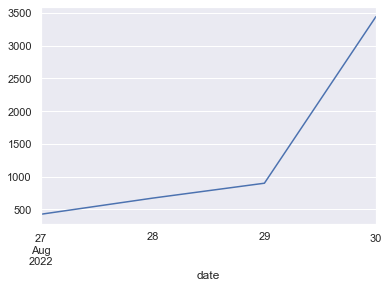

In [132]:
twit_by_date_size.plot()

In [133]:
testdf= tweets.groupby(['date'])['like_count', 'quote_count', 'reply_count', 'retweet_count',].sum()

/var/folders/rw/1rnjc7b90vd_mr3753j04_s40000gp/T/ipykernel_93262/4062091766.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  testdf= tweets.groupby(['date'])['like_count', 'quote_count', 'reply_count', 'retweet_count',].sum()


In [134]:
testdf.reset_index(inplace=True)

In [135]:
testdf.head()

,date,like_count,quote_count,reply_count,retweet_count
0,2022-08-27,386,6,64,18381
1,2022-08-28,544,15,124,27484
2,2022-08-29,595,33,162,92319
3,2022-08-30,630,17,178,3082256


<AxesSubplot:xlabel='date'>

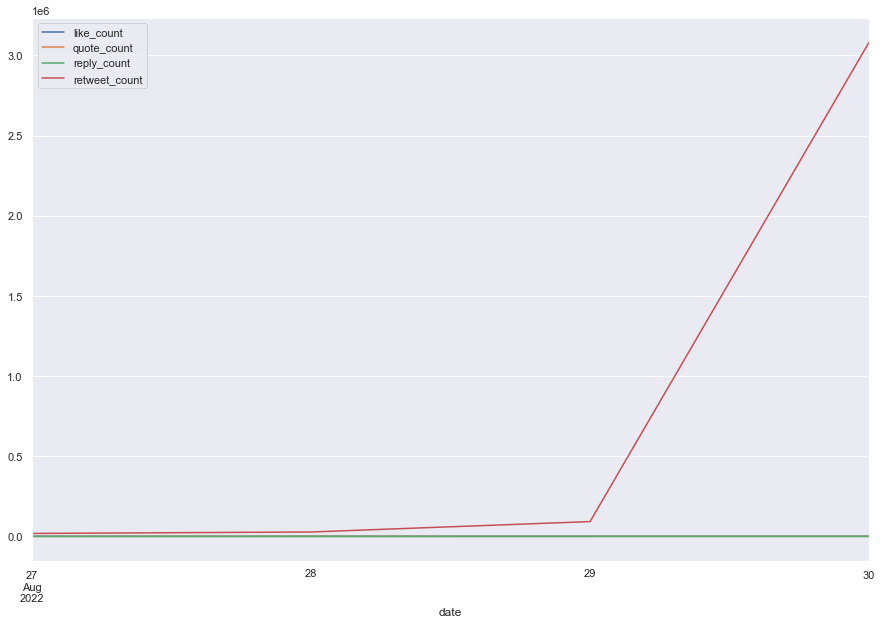

In [136]:
testdf.plot(kind='line', x='date', figsize=(15,10))

In [137]:
print("There are {} different users".format(users['username'].nunique()))

There are 5040 different users


In [138]:
usertweets = tweets.groupby('author_id')

In [139]:
top_users = usertweets.count()['tweet_text'].sort_values(ascending = False)[:25]
top_users_dict = top_users.to_dict()
user_ordered_dict = sorted(top_users_dict.items(), key=lambda x:x[1])
user_ordered_dict = user_ordered_dict[::-1]

dict_values = []
dict_keys = []
for item in user_ordered_dict[0:25]:
    dict_keys.append(item[0])
    dict_values.append(item[1])

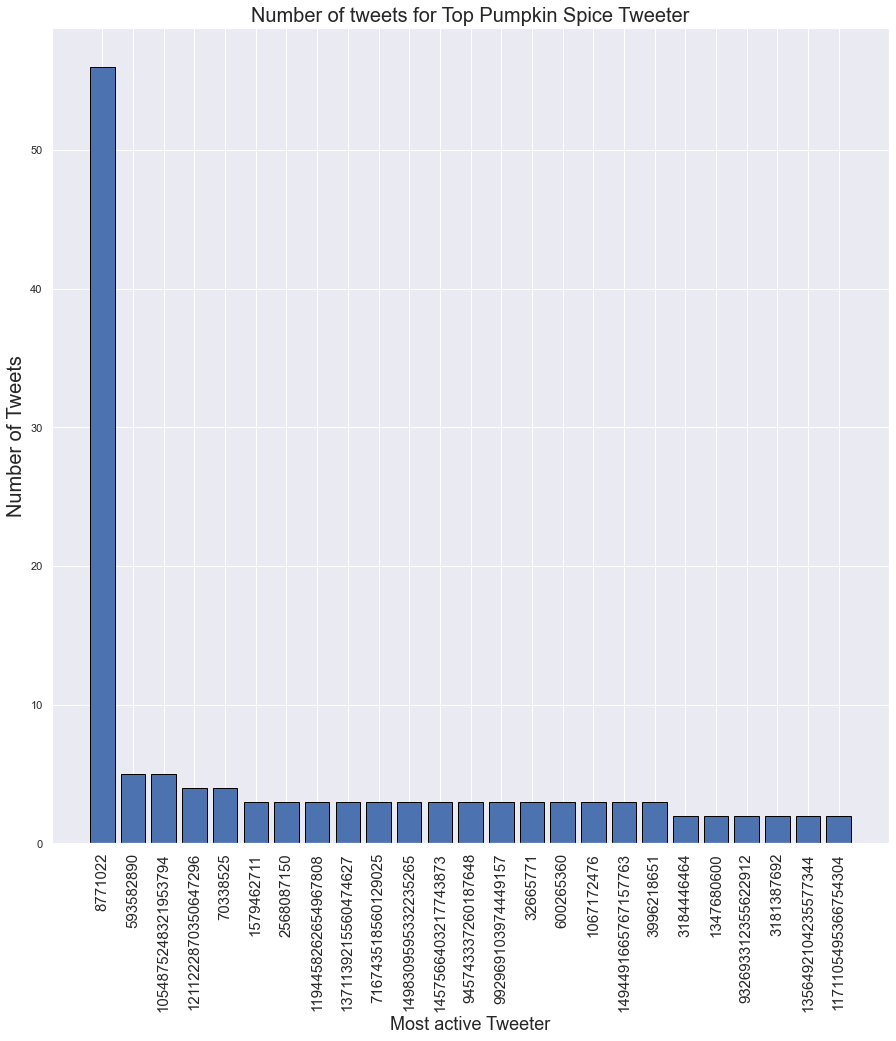

In [140]:
fig = plt.figure(figsize = (15,15))
index = np.arange(25)
plt.bar(index, dict_values, edgecolor = 'black', linewidth=1)
plt.xlabel('Most active Tweeter', fontsize = 18)
plt.ylabel('Number of Tweets', fontsize=20)
plt.xticks(index,dict_keys, fontsize=15, rotation=90)
plt.title('Number of tweets for Top Pumpkin Spice Tweeter', fontsize = 20)
plt.show()

In [141]:
# def is_RT(tweets):
#     if tweets['tweet_text'].str.contains('RT'):
#         return True
#     else:
#         return False

def is_RT(tweets):
    if 'RT' in tweets:
        return True
    else:
        return False

In [142]:
tweets['RT'] = tweets['tweet_text'].apply(lambda x: is_RT(x))

In [143]:
#See the percentage of tweets from the initial set that are retweets:
RT_tweets = tweets[tweets['RT'] == True]
print(f"The percentage of retweets is {round(len(RT_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of retweets is 43% of all the tweets


In [144]:
tweets['Reply'] = tweets['tweet_text'].str.startswith('@')
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False


In [145]:
reply_tweets = tweets[tweets['Reply'] == True]
print(f"The percentage of tweet replies is {round(len(reply_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweet replies is 14% of all the tweets


In [146]:
mention_tweets = tweets[(tweets['RT']==False) & (tweets['Reply'] == False) & (tweets['tweet_text'].str.contains('@'))]
print(f"The percentage of mentions is {round(len(mention_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of mentions is 3% of all the tweets


In [147]:
plain_text_tweets = tweets[~tweets['tweet_text'].str.contains("@")  & ~tweets['tweet_text'].str.contains("RT")]
print(f"The percentage of retweets is {round(len(plain_text_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of retweets is 40% of all the tweets


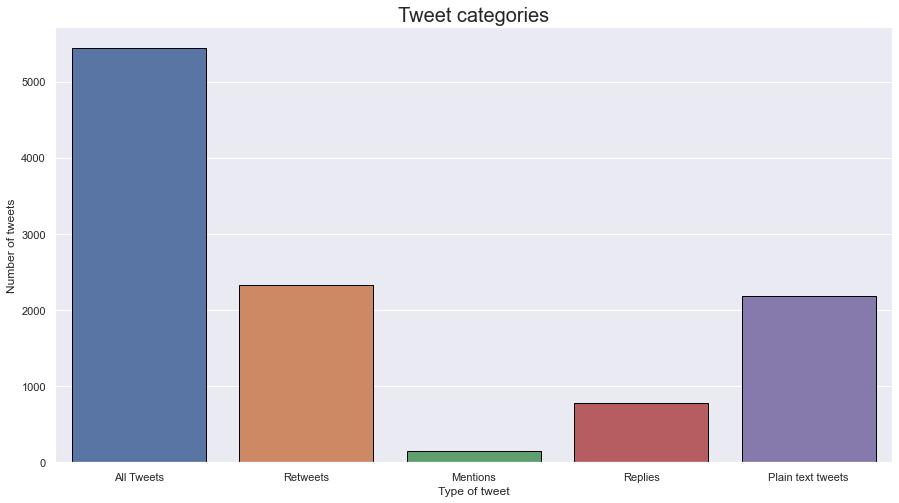

In [148]:
len_list = [ len(tweets), len(RT_tweets),len(mention_tweets), len(reply_tweets), len(plain_text_tweets)]
item_list = ['All Tweets','Retweets', 'Mentions', 'Replies', 'Plain text tweets']
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
plt.title('Tweet categories', fontsize = 20)
plt.xlabel('Type of tweet')
plt.ylabel('Number of tweets')
sns.barplot(x = item_list, y = len_list,  edgecolor = 'black', linewidth=1)

plt.show()

In [149]:
#Going to see the most used hashtags.
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets['tweet_text'].apply(hashtag_pattern.findall))

In [150]:
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

In [151]:
hashtag_ordered_list = sorted(hashtag_dict.items(), key=lambda x: x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#making list of the most used hashtags and their values

In [152]:
hashtag_ordered_values = []
hashtag_ordered_keys = []

for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])
    
#separating hashtags and values into lists, picking top 20 hashtags to plot

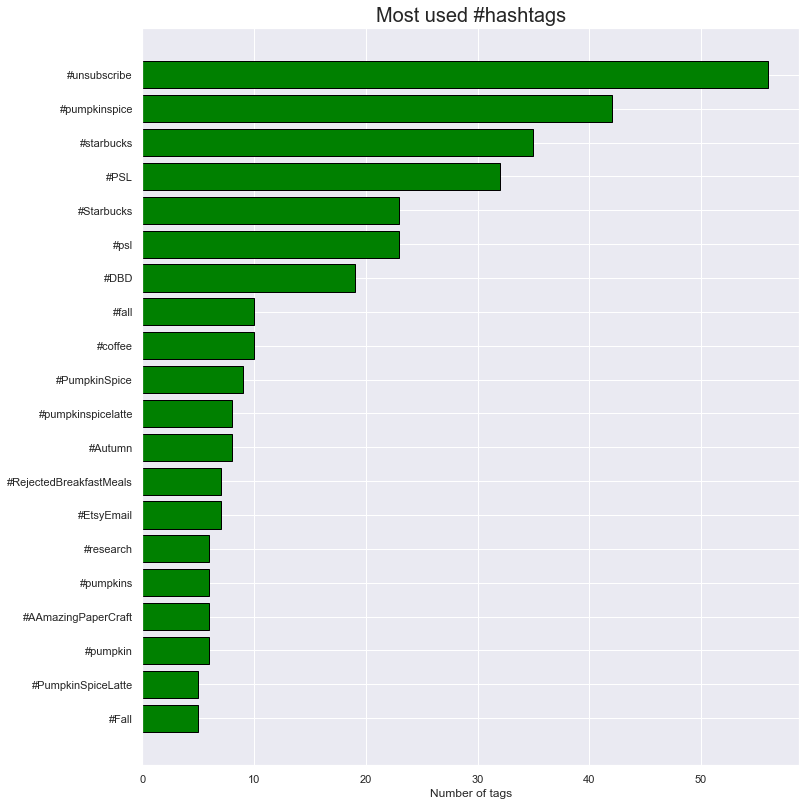

In [153]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos, list(hashtag_ordered_values)[::-1], align='center', color='green', edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Number of tags")
ax.set_title("Most used #hashtags", fontsize = 20)
plt.tight_layout(pad=3)

plt.show()

#graph with most used hashtags

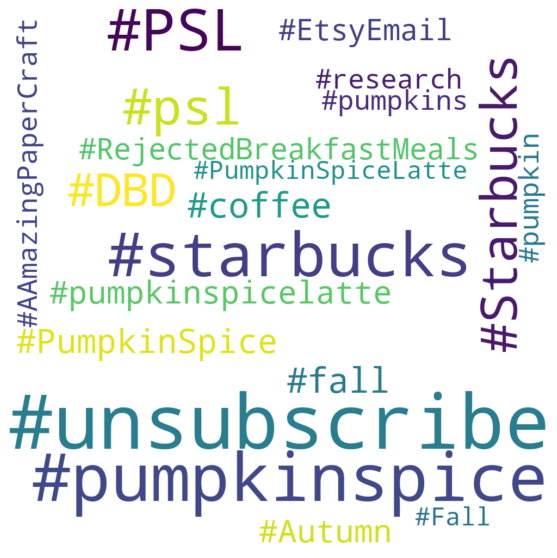

In [154]:
hashtag_ordered_dict = {}
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_dict[item[0]] = item[1]
    
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(hashtag_ordered_dict)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

#make wordcloud plot of the most used hashtags.
#use dictionary where the keys are words and the values are the number of appearances

In [155]:
mentions = []
mention_pattern = re.compile(r"@[a-zA-z_]+")
mention_matches = list(tweets['tweet_text'].apply(mention_pattern.findall))


In [156]:
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1
            

In [157]:
mentions_ordered_list = sorted(mentions_dict.items(), key=lambda x: x[1])
mentions_ordered_list = mentions_ordered_list[::-1]

#ordered list with most mentioned users and count of mentions

In [158]:
mentions_ordered_values = []
mentions_ordered_keys = []

for item in mentions_ordered_list[:20]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])
    
#top 20 mentioned users and values in two lists

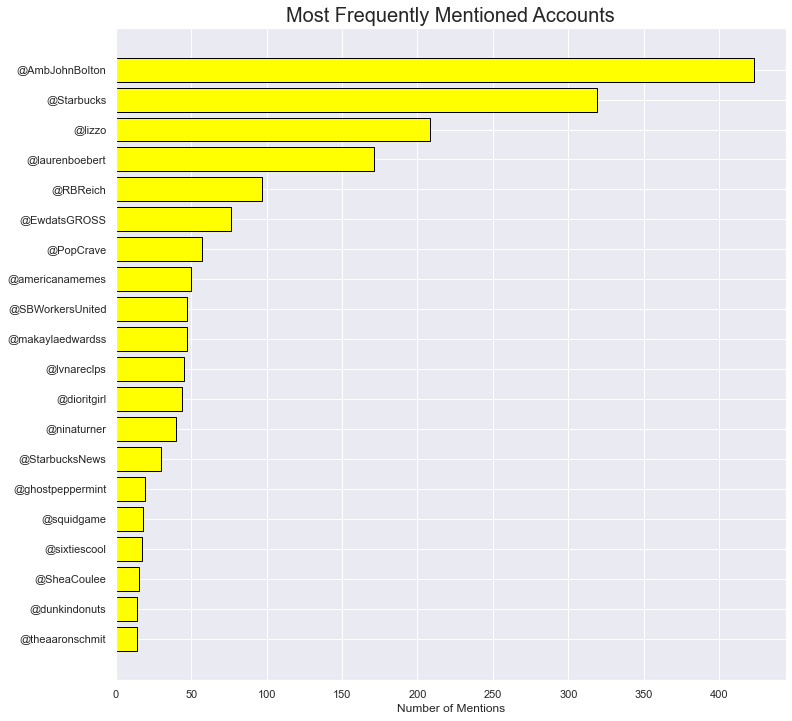

In [159]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(mentions_ordered_values))
ax.barh(y_pos, list(mentions_ordered_values)[::-1], align='center', color='yellow', edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_xlabel("Number of Mentions")
ax.set_title("Most Frequently Mentioned Accounts", fontsize = 20)

plt.show()

#graph of most mentioned accounts

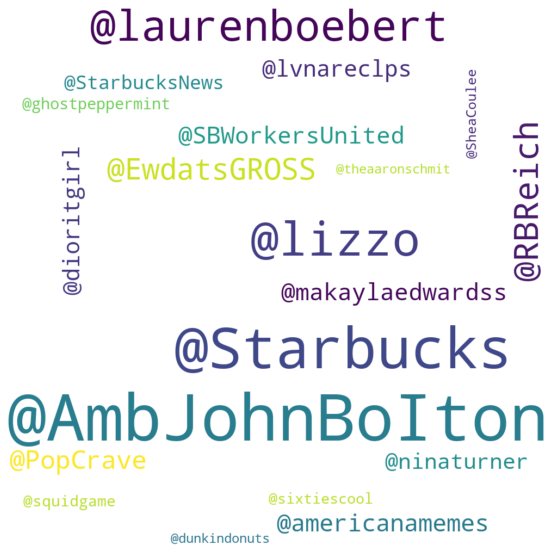

In [160]:
#mentions wordcloud just like replies word cloud

mentions_ordered_dict = {}
for item in mentions_ordered_list[:20]:
    mentions_ordered_dict[item[0]] = item[1]
    
wordcloud = WordCloud(width=1000,height=1000, random_state=21, max_font_size=200,background_color='white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [161]:
# Tweet sentiment Analysis

train, test = model_selection.train_test_split(tweets, test_size=0.3, train_size=0.7, random_state=10)

In [162]:
len(train)

3807

In [163]:
len(test)

1632

In [164]:
# Get stop words to omit from analysis
from nltk.corpus import stopwords
stopword = stopwords.words('english')
# adding some irrelevant words to our stopwords after running the tokenizer below.
extended_stop = ['https', 'stud_status', '//t.co/7pw885i0zw', 'ashnikko', 'lvnareclps', "n't", 'digitalprex', '//t.co/qthygenygi',
                 'ik', 'een', 'heb', 'ca', 'teresamaly', 'bigtoofedblonde', 'ikuflyinn', 'mi', 'llego', 'en', 'kaars', 'botten',
                 'kaarsen', 'fuck', 'fuc', 'bitch']
stopword.extend(extended_stop)

In [165]:
# Define tokenization function

def common_word_getter(row):
    words = row.tweet_text.lower()
    words = nltk.word_tokenize(words)
    frequency = nltk.FreqDist(words)
    frequency = [(w, f) for (w, f) in frequency.items() if w.lower() not in stopword]
    frequency = [(w, f) for (w, f) in frequency if len(w) > 1]
    frequency.sort(key=lambda tup: tup[1], reverse=True)
    most_common = frequency[:5]
    return most_common

In [166]:
common_list = []

for index, row in train.iterrows():
    common_list.extend([i[0] for i in common_word_getter(row)])

In [167]:
common_list[:50]

['pumpkin',
 'rt',
 'starbucksnews',
 'spice',
 'latte',
 'almost',
 'fall',
 'lets',
 'round',
 'pumpkin',
 'screams',
 'pumpkin',
 'spice',
 '//t.co/ge7o8tpej2',
 'pumpkin',
 'spice',
 'latte',
 'yet',
 'lovexmonsters',
 'yep',
 'always',
 'sweet',
 'bland',
 'rt',
 'ambjohnboiton',
 'pumpkin',
 'spice',
 'lattes',
 'rt',
 'ambjohnboiton',
 'pumpkin',
 'spice',
 'lattes',
 'rt',
 'rbreich',
 'else',
 'thinks',
 'starbucks',
 'got',
 'pumpkin',
 'spice',
 'latte',
 'oat',
 'rt',
 'ambjohnboiton',
 'pumpkin',
 'spice',
 'lattes',
 'rt',
 'kencrossing22']

In [168]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [169]:
vect = CountVectorizer(stop_words=stopword, max_features=10)

In [170]:
train_vectors = vect.fit_transform(train.tweet_text)
train_vectors

/opt/homebrew/Cellar/jupyterlab/3.4.5/libexec/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['7pw885i0zw', 'co', 'qthygenygi'] not in stop_words.
  warnings.warn(


<3807x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14345 stored elements in Compressed Sparse Row format>

In [171]:
vect.get_feature_names_out()

array(['back', 'co', 'fall', 'latte', 'lattes', 'pumpkin', 'rt', 'season',
       'spice', 'starbucks'], dtype=object)

In [172]:
test_vectors = vect.transform(test.tweet_text)
test_vectors

<1632x10 sparse matrix of type '<class 'numpy.int64'>'
	with 6152 stored elements in Compressed Sparse Row format>

In [173]:
average_vector = train_vectors.mean(axis=0)
average_vector

matrix([[0.19096401, 0.4024166 , 0.08536906, 0.33963751, 0.12792225,
         1.05988968, 0.428684  , 0.09692671, 0.98371421, 0.23115314]])

In [174]:
scores = cosine_distances(X=average_vector, Y=test_vectors)
scores

/opt/homebrew/Cellar/jupyterlab/3.4.5/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.2145782 , 0.24180016, 0.20285707, ..., 0.20285707, 0.30245319,
        0.17511068]])

In [175]:
from wordcloud import WordCloud, STOPWORDS
print(type(STOPWORDS))
STOPWORDS.update(extended_stop)

<class 'set'>


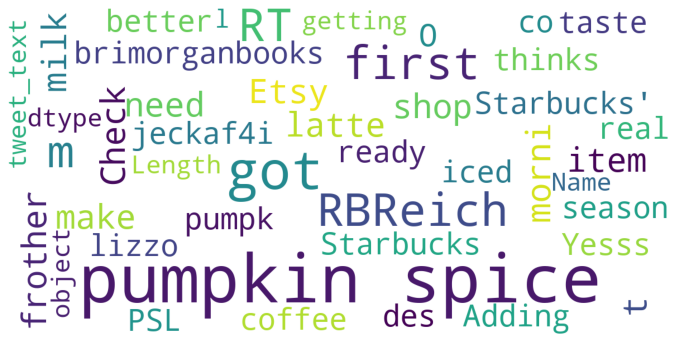

In [176]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(tweets['tweet_text'])

In [177]:
import re

def remove_stopwords_from_tweets(tweet):
    updated_tweet = tweet
    updated_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    updated_tweet = " ".join(word for word in updated_tweet.split() if word not in (stopword))
    return updated_tweet

In [178]:
tweets['updated_tweet'] = tweets['tweet_text'].apply(lambda x: remove_stopwords_from_tweets(x.lower()))
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False,first pumpkin spice latte morning
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False,got pumpkin spice iced coffee ready start day


In [179]:
from textblob import TextBlob

tweets['polarity'] = tweets['updated_tweet'].apply(lambda x: TextBlob(x).sentiment[0])
tweets.loc[tweets['polarity'] < 0]

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...,-0.600000
9,1563557669755326464,8771022,@IsraelG18676630 You’re in! We’ll make sure yo...,0,0,0,0,None,2022-08-27,False,True,make sure miss 3 medium pumpkin cream cold bre...,-0.050000
14,1563557149330251777,1548518234504273922,Pumpkin Spice makes my nipples hard! \n\n#sexy...,1,0,0,0,None,2022-08-27,False,False,pumpkin spice makes nipples hard sexysaturday ...,-0.291667
17,1563557042299645953,79327509,I have no money but pumpkin spice cold brew is...,0,0,0,0,None,2022-08-27,False,False,money pumpkin spice cold brew back,-0.300000
22,1563556599553110020,861336442542276609,RT @stanzipotenza: Now that we’re entering fal...,0,0,0,157,None,2022-08-27,True,False,rt entering fall territory one cares anti pump...,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,1564714509834637314,929136268134535168,RT @jenresisted: @laurenboebert Your husband s...,0,0,0,47,None,2022-08-30,True,False,rt husband showed penis minors definitely outr...,-0.900000
5384,1564714407694843904,1223439333312618496,@likedemolition I hate pumpkin spice shit. It’...,0,0,0,0,None,2022-08-30,False,True,hate pumpkin spice shit mind control,-0.500000
5399,1564714314119913473,748686421,RT @A_Curious_Fox: So what if I like pumpkin s...,0,0,0,36,None,2022-08-30,True,False,rt curious fox like pumpkin spice tftuesday tr...,-0.100000
5415,1564714193458057216,1721312508,Can someone bring me a pumpkin spice cold brew...,0,0,0,0,None,2022-08-30,False,False,someone bring pumpkin spice cold brew work ple...,-0.600000


In [180]:
# our negative sentiment doesn't appear totally accurate...
tweets.loc[tweets['polarity'] == 0]

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.0
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.0
6,1563557799228948480,94270683,i’ve acquired a pumpkin spice https://t.co/HE7...,2,0,1,0,None,2022-08-27,False,False,acquired pumpkin spice,0.0
8,1563557674394210304,1472635069403594752,@BigToofedBlonde Was a whiff of pumpkin spice?...,0,0,0,0,None,2022-08-27,False,True,whiff pumpkin spice,0.0
10,1563557473604096009,873287203928944640,@Starbucks so when can I get my Pumpkin Spice ...,0,0,0,0,,2022-08-27,False,True,get pumpkin spice latte,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,1564714063900291072,4870386890,RT @ghostpeppermint: Of course Wesker had to w...,0,0,0,50,,2022-08-30,True,False,rt course wesker wait pumpkin spice released f...,0.0
5431,1564714056274964480,797902650435960832,RT @americanamemes: People in LA when it’s Pum...,0,0,0,258,None,2022-08-30,True,False,rt people la pumpkin spice latte season gonna ...,0.0
5432,1564714026277429248,726873317144039425,RT @EwdatsGROSS: PSA: the food pyramid has bee...,0,0,0,368,None,2022-08-30,True,False,rt psa food pyramid updated spooky season look...,0.0
5433,1564714026067705856,2913990017,RT @EwdatsGROSS: PSA: the food pyramid has bee...,0,0,0,368,None,2022-08-30,True,False,rt psa food pyramid updated spooky season look...,0.0


In [181]:
tweets['sentiment'] = tweets['polarity'].apply(lambda x: 'positive' if x > 0 else('negative' if x<0 else 'neutral'))
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity,sentiment
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.00,neutral
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...,-0.60,negative
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False,first pumpkin spice latte morning,0.25,positive
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.00,neutral
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False,got pumpkin spice iced coffee ready start day,0.20,positive


In [182]:
tweet_sentiment = tweets.groupby(tweets['sentiment'])

In [183]:
tweets.loc[tweets['sentiment']=='neutral']

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity,sentiment
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.0,neutral
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.0,neutral
6,1563557799228948480,94270683,i’ve acquired a pumpkin spice https://t.co/HE7...,2,0,1,0,None,2022-08-27,False,False,acquired pumpkin spice,0.0,neutral
8,1563557674394210304,1472635069403594752,@BigToofedBlonde Was a whiff of pumpkin spice?...,0,0,0,0,None,2022-08-27,False,True,whiff pumpkin spice,0.0,neutral
10,1563557473604096009,873287203928944640,@Starbucks so when can I get my Pumpkin Spice ...,0,0,0,0,,2022-08-27,False,True,get pumpkin spice latte,0.0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,1564714063900291072,4870386890,RT @ghostpeppermint: Of course Wesker had to w...,0,0,0,50,,2022-08-30,True,False,rt course wesker wait pumpkin spice released f...,0.0,neutral
5431,1564714056274964480,797902650435960832,RT @americanamemes: People in LA when it’s Pum...,0,0,0,258,None,2022-08-30,True,False,rt people la pumpkin spice latte season gonna ...,0.0,neutral
5432,1564714026277429248,726873317144039425,RT @EwdatsGROSS: PSA: the food pyramid has bee...,0,0,0,368,None,2022-08-30,True,False,rt psa food pyramid updated spooky season look...,0.0,neutral
5433,1564714026067705856,2913990017,RT @EwdatsGROSS: PSA: the food pyramid has bee...,0,0,0,368,None,2022-08-30,True,False,rt psa food pyramid updated spooky season look...,0.0,neutral


In [184]:
tweet_sentiment.size()

sentiment
negative     693
neutral     2925
positive    1821
dtype: int64

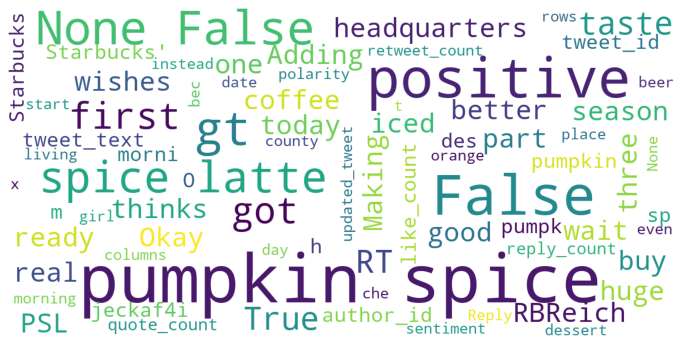

In [185]:
# positive sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'positive'])

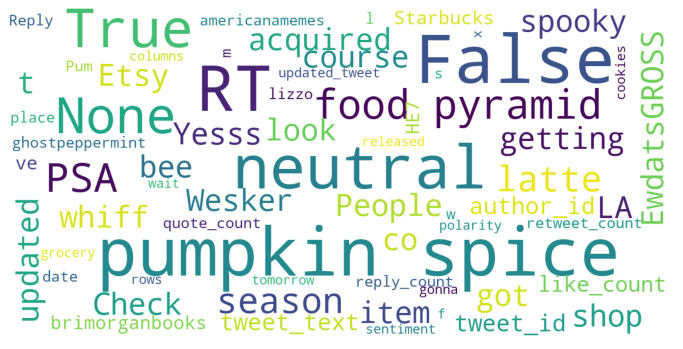

In [186]:
# neutral sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'neutral'])

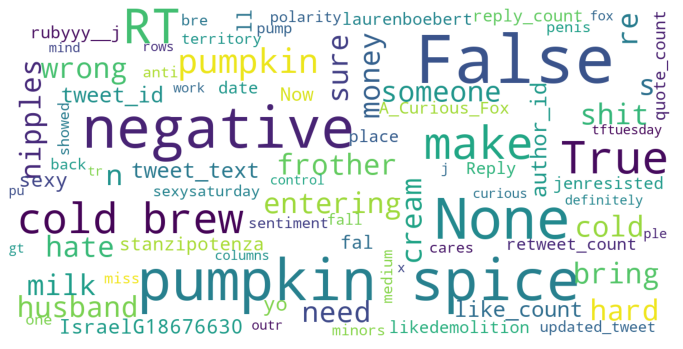

In [187]:
# negative sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'negative'])

In [188]:
tweets.loc[tweets['tweet_text'].str.contains("starbucks")].describe()

,like_count,quote_count,reply_count,retweet_count,polarity
count,172.000000,172.000000,172.000000,172.000000,172.000000
mean,0.319767,0.011628,0.093023,55.686047,0.062675
std,2.318768,0.152499,0.291313,102.268911,0.220970
min,0.000000,0.000000,0.000000,0.000000,-0.800000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,55.250000,0.050000
max,30.000000,2.000000,1.000000,394.000000,1.000000


In [189]:
users.loc[users['user_id'].isin(dict_keys)]



,user_id,username,location,follower_count,following_count,tweet_count,acct_created
12,8771022,dunkindonuts,"Canton, Mass.",1302002,52092,107930,2007-09-09
237,3996218651,DarthTonka1979,"Sasebo-shi, Nagasaki",249,4658,6626,2015-10-19
662,1494491665767157763,indicacloudss,she/her • ♋️ • 43/50📚,1397,1349,2190,2022-02-18
1240,3184446464,X234Kyle,"California, USA",246,547,104876,2015-05-03
1350,1579462711,moneymaj10,Brookline PA,160,1955,3965,2013-07-09
1384,1171105495366754304,vrogersdesigns,"austin, tx",16917,150,8063,2019-09-09
1488,593582890,80suburbia,DMs closed,6032,4231,330215,2012-05-29
1543,2568087150,FlorenceCarmela,"Connecticut, USA",22115,21695,55668,2014-06-15
1587,1067172476,dcfoodsafety,None,5112,3525,136808,2013-01-07
1612,1054875248321953794,matthew_leal,"Kansas, USA",591,4997,30254,2018-10-23


In [190]:
mergedDF = pd.merge(tweets, users, how="left", left_on="author_id", right_on="user_id")
